In [1]:
headers = {
    'x-rapidapi-key': "ce78bda1b8msh986aee44aa8d2a2p1f47fcjsndb822269c7d4",
    'x-rapidapi-host': "apidojo-yahoo-finance-v1.p.rapidapi.com"
    }

In [2]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

import requests
import json
import pandas as pd
import itertools as it
import matplotlib.pyplot as plt
import statsmodels as sm
import statsmodels.tsa as tsa
import statsmodels.graphics.tsaplots
import statsmodels.tsa.arima.model
import statsmodels.tsa.stattools

In [3]:
url = "https://apidojo-yahoo-finance-v1.p.rapidapi.com/stock/v2/get-chart"

querystring = {"interval":"1m","symbol":"AAPL","region":"US","period1":"1618417800","period2":"1618421400"}

response = requests.request("GET", url, headers=headers, params=querystring)

data = json.loads(response.text)
_index=pd.DatetimeIndex(pd.to_datetime(data['chart']['result'][0]['timestamp'], unit='s'), freq='T')
ts = pd.Series(data['chart']['result'][0]['indicators']['quote'][0]['close'], index=_index)
train, test = ts[:50], ts[50:]
print(ts.head())

2021-04-14 16:30:00    133.277695
2021-04-14 16:31:00    133.180099
2021-04-14 16:32:00    133.244995
2021-04-14 16:33:00    133.240005
2021-04-14 16:34:00    133.270004
Freq: T, dtype: float64


In [4]:
diffed = train.copy()
d = 0
while tsa.stattools.adfuller(diffed.dropna())[1] > 0.25:
    diffed = diffed.diff()
    d += 1
print("d parameter:", d)

d parameter: 0


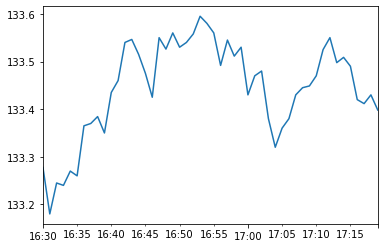

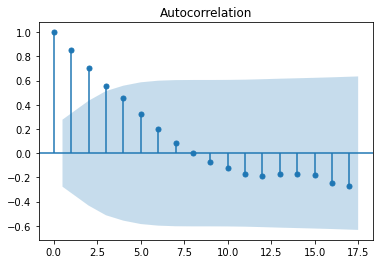

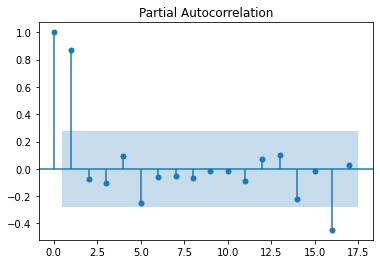

In [5]:
diffed.dropna().plot()
sm.graphics.tsaplots.plot_acf(diffed.dropna());
sm.graphics.tsaplots.plot_pacf(diffed.dropna());

In [6]:
ars = [0, 1, 5, 16]
mas = [0, 1, 2, 3, 4]
models = dict()
results = dict()
for p, q in it.product(ars, mas):
    models[(p, q)] = tsa.arima.model.ARIMA(train, order=(p, d, q), missing='drop')
    results[(p, q)] = models[(p, q)].fit()

/usr/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


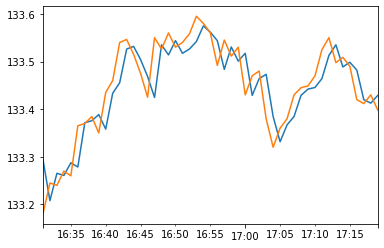

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   50
Model:                 ARIMA(1, 0, 0)   Log Likelihood                  80.111
Date:                Thu, 29 Apr 2021   AIC                           -154.221
Time:                        22:41:59   BIC                           -148.485
Sample:                    04-14-2021   HQIC                          -152.037
                         - 04-14-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        133.4201      0.047   2830.832      0.000     133.328     133.512
ar.L1          0.8842      0.070     12.641      0.000       0.747       1.021
sigma2         0.0023      0.000      5.090      0.0

In [7]:
pars = min(results.items(), key=lambda x: x[1].aicc)[0]
result = results[pars]
result.fittedvalues[1:].plot()
train[1:].plot()
plt.show()
print(result.summary())

,lb_stat,lb_pvalue
1,0.016477,0.897862
2,0.100626,0.950932
3,0.991521,0.803304
4,2.618196,0.623603
5,2.690976,0.747498
6,2.698765,0.845593
7,3.001967,0.884820
8,3.186608,0.922107
9,3.843020,0.921437
10,3.851999,0.953777


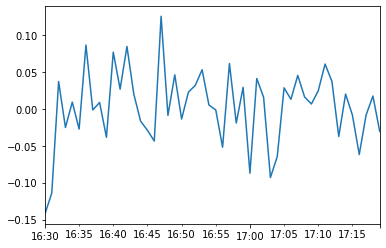

In [8]:
result.resid.plot()
sm.stats.diagnostic.acorr_ljungbox(result.resid, return_df=True, lags=20)

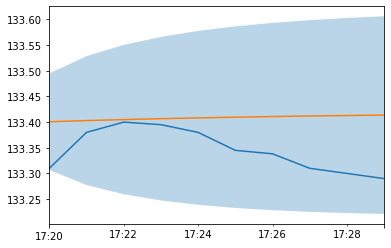

In [9]:
pred = result.forecast(len(test))
fore = result.get_forecast(len(test))
conf = fore.conf_int()
test.plot()
pred.plot()
plt.fill_between(conf.index, conf['lower y'], conf['upper y'], alpha=0.3)
plt.show()